In [2]:
%matplotlib inline
main_path = './../../../Dropbox/McGill-publication/Papers/Multisite/'

In [3]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

def load_file(path):
    mat = scipy.io.loadmat(path)
    return mat

path_csv = 'demographic_1000fcon_consolidated.csv'
demograph = pd.read_csv(path_csv, index_col=0)
#subj_names = demograph[demograph.multisite == 1].values[:,0]
subj_names = demograph[demograph.multisite == 1].index.values

conn = load_file(main_path + 'figures/connectomes_corr/connectome_basc_' + 'sub19738' + '.mat' )
conn.get('conn').shape

(4950, 1)

In [42]:
subj_names
print demograph.sex.mean(),demograph.sex.std()
print demograph.age.mean(),demograph.age.std()

0.417391304348 0.493844823612
23.8579710145 5.14782652818


In [5]:
np.sum(demograph.multisite == 8)

print(np.sum([23,26,198,19,20,22,19,31]))
print(np.sum([21,26,195,17,18,20,17,31]))

358
345


In [4]:
from sklearn import linear_model
from sklearn.preprocessing import normalize


def rmconf(x,conf):
    print(x.shape,conf.shape)
    reg = linear_model.LinearRegression(fit_intercept=True)
    reg.fit(normalize(conf), x)
    return  x - reg.predict(normalize(conf))
    

    

In [69]:
demograph.loc['sub19738'].values[[0,2,3]]

array([  0.22675753,  27.        ,   0.        ])

In [26]:
import re, os
path = main_path + '/figures/connectomes_corr/'
list_connectomes = os.listdir(path)

demog_tmp = list()
all_conn_sites = list()
groups_vec = []
demog_tmp=[]
k=0
for site in range(1,9):
    # retrieve the subject name for that site
    subj_names = demograph[demograph.multisite == site].index.values

    for subj_name in subj_names:
        try:
            subj_name = subj_name.replace(' ','')
            conn_vec = load_file(path + 'connectome_basc_' +subj_name+'.mat' ).get('conn')
            
            if k==0:
                all_conn_sites = conn_vec
                demog_tmp.append(demograph.loc[subj_name].values[[0,2,3]])
                k=1
            else:
                all_conn_sites = np.hstack([all_conn_sites , conn_vec])
                demog_tmp = np.vstack((demog_tmp,demograph.loc[subj_name].values[[0,2,3]]))
            
            groups_vec.append(site)
        except Exception as e: 
            print(e)
            pass
        
#print all_conn_sites.shape,demog_tmp.shape
groups_vec = np.array(groups_vec)

# detrend the connections
#detrended_conn_all = rmconf(all_conn_sites.T,demog_tmp)

list_conn_sites = list()
detrended_conn = list()
demog_data = list()
for site in range(1,9):
    # retrieve the subject name for that site
    subj_names = demograph[demograph.multisite == site].index.values
    
    detrended_conn.append(detrended_conn_all[groups_vec == site,:])
    demog_data.append(demog_tmp[groups_vec == site,:])
    k=0
    for subj_name in subj_names:
        try:
            subj_name = subj_name.replace(' ','')
            conn_vec = load_file(path + 'connectome_basc_' +subj_name+'.mat' ).get('conn')
            if k==0:
                conns_stack = conn_vec
                k=1
            else:
                conns_stack = np.hstack([conns_stack , conn_vec])
        except Exception as e: 
            print(e)
            pass
        #print(conns_stack.shape)
    list_conn_sites.append(conns_stack.copy())
            
#list_conn_sites

import statsmodels.api as sm
#detrended_conn_all = rmconf(all_conn_sites.T,demog_tmp)



[Errno 2] No such file or directory: './../../../Dropbox/McGill-publication/Papers/Multisite//figures/connectomes_corr/connectome_basc_sub55760.mat'
[Errno 2] No such file or directory: './../../../Dropbox/McGill-publication/Papers/Multisite//figures/connectomes_corr/connectome_basc_sub24528.mat'
[Errno 2] No such file or directory: './../../../Dropbox/McGill-publication/Papers/Multisite//figures/connectomes_corr/connectome_basc_sub55760.mat'
[Errno 2] No such file or directory: './../../../Dropbox/McGill-publication/Papers/Multisite//figures/connectomes_corr/connectome_basc_sub24528.mat'


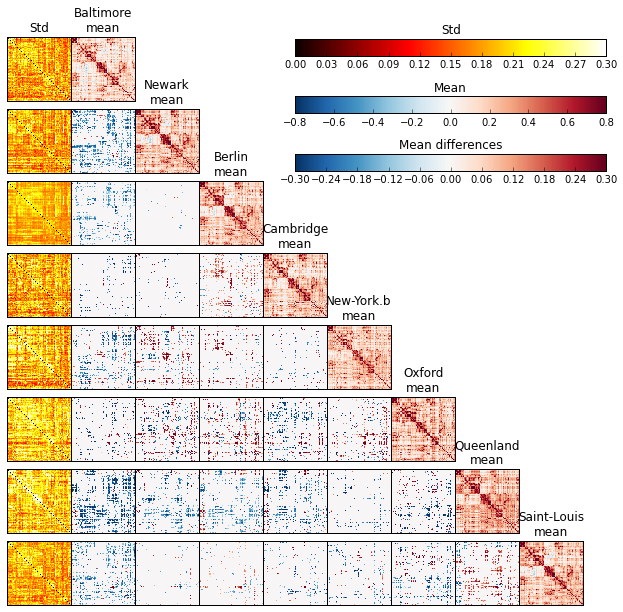

In [84]:
from Proteus.proteus.predic import clustering as hc
from Proteus.proteus.matrix import tseries as ts
from Proteus.proteus.visu import matrix as vis
import matplotlib.gridspec as gridspec
from scipy import stats
import statsmodels.stats.multitest as smm

reload(vis)
#reload(vis.matrix)
reload(ts)
reload(hc)

def get_stats(conns):
    # compute the mean, std, ...   
    return ts.vec2mat(conns.mean(axis=1)), ts.vec2mat(conns.std(axis=1),val_diag=0)

def gen_fig(list_conn_sites):
    
    for sidx in range(0,len(list_conn_sites)):

        conn_vec = list_conn_sites[sidx]
        site_mean, site_std = get_stats(conn_vec)
        #print(site_mean.min(),site_mean.max(), site_std.min(),site_std.max())
        if sidx == 0:
            all_sites = site_mean
        else:
            all_sites = all_sites + site_mean
            
        all_sites = all_sites / len(list_conn_sites)

    order = hc.hclustering(all_sites, 100)
    #ordered_mat = hc.ordermat(all_sites,order)
    #vis.mat(ordered_mat)
    
    site_names = ['Baltimore','Newark','Berlin','Cambridge','New-York.b','Oxford','Queenland','Saint-Louis']
    lim_mean = [-0.8,0.8]
    lim_mean_diff = [-0.3,0.3]
    lim_std  = [0,.3]
    fig = plt.figure(figsize=(16, 16),dpi=150)
    fig.patch.set_facecolor('white')
    grid1 = gridspec.GridSpec(1,len(list_conn_sites)+1, wspace=0.0, hspace=0.0)
    grid1.update(wspace=0, hspace=0.0, bottom=0.0, top=0.5, left=0, right=0.5)
    for sidx in range(0,len(list_conn_sites)+1):
        
        if sidx > 0:
            conn_vec = list_conn_sites[sidx-1]
            site_mean, site_std = get_stats(conn_vec)
        
        # compare to all other sites
        for site_diff_idx in range(0,len(list_conn_sites)):
            grid2 = gridspec.GridSpecFromSubplotSpec(len(list_conn_sites),1, subplot_spec=grid1[sidx], wspace=0.0, hspace=0.0)
            #grid2 = gridspec.GridSpec(len(list_conn_sites), 2, subplot_spec=grid1[sidx], wspace=0.05, hspace=0.0)
            #gs2 = gridspec.GridSpec(len(list_conn_sites), 2)
            #grid2.update(left=0.05, right=0.48, wspace=0.05)
            
            if sidx == 0:
                # include the last std at the end of the 
                site_mean_tmp, site_std_tmp = get_stats(list_conn_sites[site_diff_idx])
                ax2 = plt.subplot(grid2[site_diff_idx,:])
                vis.mat(hc.ordermat(site_std_tmp,order),lim_std,False,False)
                #plt.ylabel('std')
                if site_diff_idx == 0:
                    plt.title('Std')
                
            else:
                if site_diff_idx == sidx-1:

                    #plt.imshow(site_std, interpolation="none")
                    #plt.delaxes()
                    ax1 = plt.subplot(grid2[site_diff_idx,:])
                    vis.mat(hc.ordermat(site_mean,order),lim_mean,False,False)
                    plt.title(site_names[sidx-1] + '\nmean')

                    """
                    if (sidx!=0):
                        site_mean_tmp, site_std_tmp = get_stats(list_conn_sites[site_diff_idx-1])
                        ax2 = plt.subplot(grid2[site_diff_idx-1,:])
                        vis.matrix.mat(site_std_tmp,[0,0.5],False,False)
                        plt.title('std')
                    """

                elif site_diff_idx > sidx-1:
                    conn_vec_tmp = list_conn_sites[site_diff_idx]
                    #t, prob = scipy.stats.ttest_ind(conn_vec,conn_vec_tmp)
                    #print demog_data[sidx-1]
                    x_1 = sm.tools.add_constant(demog_data[sidx-1])
                    x_2 = sm.tools.add_constant(demog_data[site_diff_idx])
                    x_ = np.vstack((x_1,x_2))
                    contrast = np.hstack((np.ones(x_1.shape[0]),np.zeros(x_2.shape[0])))
                    #print contrast.shape,x_.shape
                    x_ = np.hstack((contrast[:,np.newaxis],x_))
                    pval = []
                    for nn in range(conn_vec.shape[0]):
                        y_ = np.hstack((conn_vec[nn,:],conn_vec_tmp[nn,:]))
                        glm_ = sm.GLM(y_, x_)
                        res = glm_.fit()
                        #print(res.summary())
                        pval.append(res.pvalues[0])
                    pval = np.array(pval)
                    #conn_vec_tmp = detrended_conn[site_diff_idx]
                    #t,pval = stats.ttest_ind(detrended_conn[sidx-1],conn_vec_tmp, axis=0, equal_var = False)
                    rejected , pvaluecorrected = smm.multipletests(pval, alpha=0.05, method='fdr_bh')[:2]
                    rejected = ts.vec2mat(rejected)
                    #print conn_vec_tmp.shape
                    site_mean_tmp, site_std_tmp = get_stats(conn_vec_tmp)
                    #site_mean, site_std = get_stats(detrended_conn[sidx-1].T)
                    ax3 = plt.subplot(grid2[site_diff_idx,:])
                    #vis.mat(hc.ordermat(np.abs(site_mean - site_mean_tmp),order),lim_mean,False,False)
                    vis.mat(hc.ordermat((site_mean - site_mean_tmp)*rejected ,order),lim_mean_diff,False,False)
                    #vis.mat(hc.ordermat(rejected ,order),lim_mean_diff,False,False)
                    #print((site_mean - site_mean_tmp).min(), (site_mean - site_mean_tmp).max())

                    

    from sklearn import linear_model
    # include the color bars 1
    lim = lim_std
    cmap = vis.get_cmap(site_std, lim)
    ax_bar = fig.add_axes([0.25, 0.48, 0.27, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap, lim)
    plt.title('Std')

    # include the color bars 2
    lim = lim_mean
    cmap = vis.get_cmap(site_mean, lim)
    ax_bar = fig.add_axes([0.25, 0.43, 0.27, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap, lim)
    plt.title('Mean')

    # include the color bars 3
    lim = lim_mean_diff
    cmap = vis.get_cmap(site_mean, lim)
    ax_bar = fig.add_axes([0.25, 0.38, 0.27, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap, lim)
    plt.title('Mean differences')
    #plt.tight_layout()
    plt.savefig(main_path + 'figures/connectome_multisite.pdf')
    plt.savefig(main_path + 'figures/connectome_multisite.png')
    #plt.show()
                

gen_fig(list_conn_sites)

site_mean, site_std = get_stats(conns_stack)
#vis.matrix.mat(site_mean,[-1,1.3])
#vis.matrix.mat(site_mean)



343

## Matrix brain

('STD ', 0.18888100340207475, 0.0, 0.33386157108027464)
('MEAN ', 0.26064510455601442, -0.2847066630194664, 1.2733064412807522)
('mean diff ', 0.0, 0.0, 0.0)


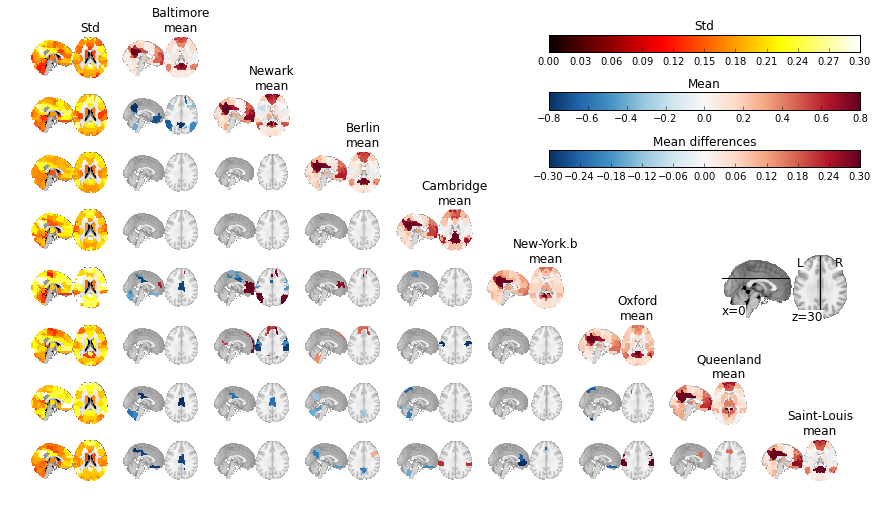

In [86]:
from Proteus.proteus.predic import clustering as hc
from Proteus.proteus.matrix import tseries as ts
from Proteus.proteus.visu import matrix as vis
import matplotlib.gridspec as gridspec
from matplotlib.pylab import *
#reload(vis.matrix)
reload(ts)
reload(hc)
import copy
import nilearn
from nilearn import plotting
import nibabel as nib

def mapvec(v,partition):
    new_map = copy.deepcopy(partition)
    im = new_map.get_data()
    
    part = partition.get_data()  
    for i in range(len(v)):
        idxs = np.where(part==(i+1))
        im[idxs] = v[i]
    return new_map



def get_stats(conns):
    # compute the mean, std, ...   
    return ts.vec2mat(conns.mean(axis=1)), ts.vec2mat(conns.std(axis=1),val_diag=0)

def gen_fig_gb(list_conn_sites):
    
    selected_network_idx = 0
    cutcoor = (0, 30)
    
    #im_ref = nib.load('basc_cambridge_sc100.mnc')
    im_ref = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/Multisite/figures/network_basc.mnc')
    im_ref = nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())
    
    for sidx in range(0,len(list_conn_sites)):

        conn_vec = list_conn_sites[sidx]
        site_mean, site_std = get_stats(conn_vec)
        if sidx == 0:
            all_sites = site_mean
        else:
            all_sites += site_mean
            
        all_sites /= len(list_conn_sites)
    
    im_ref_tmp = nib.Nifti1Image(im_ref.get_data(), im_ref.get_affine())
    
    nn_map = mapvec(all_sites[selected_network_idx,:],im_ref_tmp)
    nn_map.to_filename('dmn_img.nii')

    #order = hc.hclustering(all_sites, 100)
    #ordered_mat = hc.ordermat(all_sites,order)
    #vis.mat(ordered_mat)
    
    site_names = ['Baltimore','Newark','Berlin','Cambridge','New-York.b','Oxford','Queenland','Saint-Louis']
    lim_mean = [-0.8,0.8]
    lim_std = [0,0.3]
    lim_mean_diff = [-0.3,0.3]
    
    fig = plt.figure(figsize=(16, 16),dpi=150)
    fig.patch.set_facecolor('white')
    grid1 = gridspec.GridSpec(1,len(list_conn_sites)+1, wspace=0.0, hspace=0.0)
    grid1.update(wspace=0.2, hspace=0.0, bottom=0.0, top=0.4, left=0, right=0.7)
    for sidx in range(0,len(list_conn_sites)+1):
        
        if sidx > 0:
            conn_vec = list_conn_sites[sidx-1]
            site_mean, site_std = get_stats(conn_vec)
        
        # compare to all other sites
        for site_diff_idx in range(0,len(list_conn_sites)):
            grid2 = gridspec.GridSpecFromSubplotSpec(len(list_conn_sites),1, subplot_spec=grid1[sidx], wspace=0.0, hspace=0.0)
            #grid2 = gridspec.GridSpec(len(list_conn_sites), 2, subplot_spec=grid1[sidx], wspace=0.05, hspace=0.0)
            #gs2 = gridspec.GridSpec(len(list_conn_sites), 2)
            #grid2.update(left=0.05, right=0.48, wspace=0.05)
            
            if sidx == 0:
                # include the last std at the end of the 
                site_mean_tmp, site_std_tmp = get_stats(list_conn_sites[site_diff_idx])
                ax2 = plt.subplot(grid2[site_diff_idx,:])
                #vis.mat(hc.ordermat(site_std_tmp,order),[0,0.7],False,False)
                nn_map = mapvec(site_std_tmp[selected_network_idx,:],im_ref)
                #cmap=vis.get_cmap(site_std_tmp[selected_network_idx,:],lim_std),                
                '''
                plotting.plot_stat_map (nn_map,
                                        cmap=cm.hot,
                                        vmax=lim_std[1],
                                        cut_coords=cutcoor,
                                        annotate=False,
                                        draw_cross=False,
                                        axes=ax2,
                                        colorbar=False,
                                        display_mode='xz'
                                        )
                                        
                
                #threshold = 0.05,
                std_map = plotting.plot_stat_map (nn_map,
                                        cmap=plotting.cm.black_red,
                                        vmin=lim_std[0],
                                        vmax=lim_std[1],
                                        annotate=False,
                                        draw_cross=False,
                                        axes=ax2,
                                        colorbar=False,
                                        display_mode='xz'
                                        )
                '''
                display = plotting.plot_anat(
                                        annotate=False,
                                        draw_cross=False,
                                        axes=ax2,
                                        colorbar=False,
                                        display_mode='xz'
                                        )

                display.add_overlay(nn_map,cmap=plotting.cm.black_red,
                                        vmin=lim_std[0],
                                        vmax=lim_std[1])
                #plt.ylabel('std')
                if site_diff_idx == 0:
                    plt.title('Std')
                
            else:
                if site_diff_idx == sidx-1:

                    #plt.imshow(site_std, interpolation="none")
                    #plt.delaxes()
                    ax1 = plt.subplot(grid2[site_diff_idx,:])
                    #vis.get_cmap(site_mean,lim_mean),
                    #vis.mat(hc.ordermat(site_mean,order),lim_mean,False,False)
                    nn_map = mapvec(site_mean[selected_network_idx,:],im_ref)
                    '''
                    plotting.plot_glass_brain (nn_map,
                                       cmap=cm.RdBu_r,
                                       vmax=lim_mean[1],
                                            cut_coords=cutcoor,
                                            annotate=False,
                                            draw_cross=False,
                                            axes=ax1,
                                            colorbar=False ,
                                            display_mode='xz'
                                            )
                    '''
                    plotting.plot_stat_map (nn_map,
                                       cmap=cm.RdBu_r,
                                       #vmin=lim_mean[0],
                                       vmax=lim_mean[1],
                                            annotate=False,
                                            draw_cross=False,
                                            axes=ax1,
                                            colorbar=False ,
                                            display_mode='xz'
                                            )
                    plt.title(site_names[sidx-1] + '\nmean')

                    """
                    if (sidx!=0):
                        site_mean_tmp, site_std_tmp = get_stats(list_conn_sites[site_diff_idx-1])
                        ax2 = plt.subplot(grid2[site_diff_idx-1,:])
                        vis.matrix.mat(site_std_tmp,[0,0.5],False,False)
                        plt.title('std')
                    """

                elif site_diff_idx > sidx-1:
                    conn_vec_tmp = list_conn_sites[site_diff_idx]
                    #t, prob = scipy.stats.ttest_ind(conn_vec,conn_vec_tmp)
                    #t,pval = stats.ttest_ind(conn_vec,conn_vec_tmp, axis=1, equal_var = False)
                    #rejected , pvaluecorrected = smm.multipletests(pval, alpha=0.05, method='fdr_bh')[:2]
                    
                    #conn_vec_tmp = detrended_conn[site_diff_idx]
                    
                    x_1 = sm.tools.add_constant(demog_data[sidx-1])
                    x_2 = sm.tools.add_constant(demog_data[site_diff_idx])
                    x_ = np.vstack((x_1,x_2))
                    contrast = np.hstack((np.ones(x_1.shape[0]),np.zeros(x_2.shape[0])))
                    #print contrast.shape,x_.shape
                    x_ = np.hstack((contrast[:,np.newaxis],x_))
                    pval = []
                    for nn in range(conn_vec.shape[0]):
                        y_ = np.hstack((conn_vec[nn,:],conn_vec_tmp[nn,:]))
                        glm_ = sm.GLM(y_, x_)
                        res = glm_.fit()
                        #print(res.summary())
                        pval.append(res.pvalues[0])
                    pval = np.array(pval)
                    
                    
                    #t,pval = stats.ttest_ind(list_conn_sites[sidx-1],conn_vec_tmp, axis=0, equal_var = False)
                    rejected , pvaluecorrected = smm.multipletests(pval, alpha=0.05, method='fdr_bh')[:2]
                    #rejected , pvaluecorrected = fdr(pval,0.05)
                    rejected = ts.vec2mat(rejected)
                    site_mean_tmp, site_std_tmp = get_stats(conn_vec_tmp)
                    site_mean, site_std = get_stats(list_conn_sites[sidx-1])
                    ax3 = plt.subplot(grid2[site_diff_idx,:])
                    #vis.mat(hc.ordermat((site_mean - site_mean_tmp)*rejected ,order),lim_mean,False,False)
                    #vis.get_cmap((site_mean - site_mean_tmp),lim_mean),
                    nn_map = mapvec(((site_mean - site_mean_tmp)*rejected)[selected_network_idx,:],im_ref)
                    #print(np.min(site_mean - site_mean_tmp),np.max(site_mean - site_mean_tmp))
                    '''
                    plotting.plot_glass_brain (nn_map,
                                            cmap=cm.RdBu_r,#vis.get_cmap((site_mean - site_mean_tmp),lim_mean),
                                            vmax=lim_mean_diff[1],
                                            cut_coords=cutcoor,
                                            annotate=False,
                                            draw_cross=False,
                                            axes=ax3,
                                            colorbar=False,
                                            display_mode='xz'
                                            )
                    '''
                    plotting.plot_stat_map (nn_map,
                                            cmap=cm.RdBu_r,#vis.get_cmap((site_mean - site_mean_tmp),lim_mean),
                                            #vmin=lim_mean_diff[0],
                                            vmax=lim_mean_diff[1],
                                            cut_coords=cutcoor,
                                            annotate=False,
                                            draw_cross=False,
                                            axes=ax3,
                                            colorbar=False,
                                            display_mode='xz'
                                            )

    # include the color bars 1
    lim = lim_std
    cmap = plotting.cm.black_red
    ax_bar = fig.add_axes([0.45, 0.38, 0.27, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap, lim)
    plt.title('Std')
    print('STD ',site_std.mean(),site_std.min(),site_std.max())

    # include the color bars 2
    lim = lim_mean
    cmap = cm.RdBu_r #vis.get_cmap(site_mean, lim)
    ax_bar = fig.add_axes([0.45, 0.33, 0.27, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap, lim)
    plt.title('Mean')
    print('MEAN ',site_mean.mean(),site_mean.min(),site_mean.max())
    diff_tmp = site_mean - site_mean_tmp
    print('mean diff ',diff_tmp.mean(),diff_tmp.min(),diff_tmp.max())
    
    # include the color bars 3
    lim = lim_mean_diff
    cmap = cm.RdBu_r #vis.get_cmap(site_mean, lim)
    ax_bar = fig.add_axes([0.45, 0.28, 0.27, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap, lim)
    plt.title('Mean differences')
    
    ax_anat = fig.add_axes([0.60, 0.12, 0.11, 0.11])
    plotting.plot_anat(cut_coords=cutcoor,
                        annotate=True,
                        axes=ax_anat,
                        colorbar=False,
                        display_mode='xz')
    
    #plt.subplots_adjust(bottom=.12,top=.95,right=0.95,left=.12)
    #plt.tight_layout()
    plt.savefig(main_path + 'figures/pccmap_multisite.pdf')
    plt.savefig(main_path + 'figures/pccmap_multisite.png')
    #plt.show()
    return all_sites
                

all_sites = gen_fig_gb(list_conn_sites)

site_mean, site_std = get_stats(conns_stack)





[[-0.07845134]
 [ 0.35939267]
 [ 0.61748241]
 [ 0.27816169]
 [ 0.11804413]]
[[ 1.         -0.07845134  0.35939267  0.61748241  0.27816169]
 [-0.07845134  1.         -0.00663689 -0.13689954  0.30034849]
 [ 0.35939267 -0.00663689  1.          0.49247207  0.69239426]
 [ 0.61748241 -0.13689954  0.49247207  1.          0.35889479]
 [ 0.27816169  0.30034849  0.69239426  0.35889479  1.        ]]
1


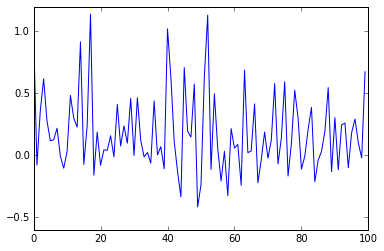

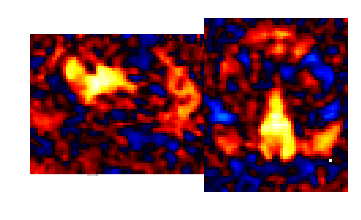

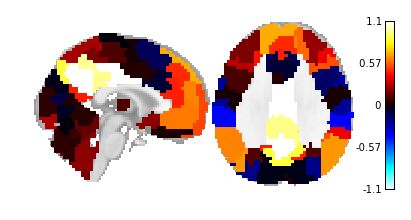

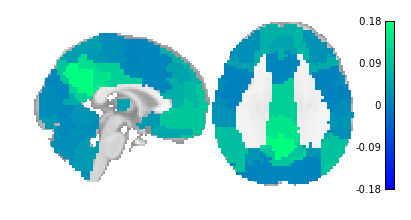

In [453]:

reload(ts)

x = load_file('/Users/christian/Dropbox/McGill-publication/Papers/Multisite/figures/connectomes/connectome_basc_sub52442' ).get('conn')
#x = load_file('/Users/christian/Dropbox/McGill-publication/Papers/Multisite/figures/rmap_sub52442_PCC.mnc.gz' ).get('conn')

a = ts.vec2mat(x)

print x[:5]
print a[:5,:5]
print a[0,:].ndim
plt.figure()
plt.plot(a[0,:])


im_ref = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/Multisite/figures/rmap_sub52442_PCC.mnc.gz')
plotting.plot_stat_map (im_ref,
                        cut_coords=(0,30),
                        annotate=False,
                        draw_cross=False,
                        colorbar=False,
                        display_mode='xz'
                        )


plt.figure()
im_ref = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/Multisite/figures/network_basc.mnc')
im_ref = nib.Minc1Image(im_ref.get_data(), im_ref.get_affine())

nn_map = mapvec(a[0,:],im_ref)
plotting.plot_stat_map (nn_map,
                        cut_coords=(0,30),
                        annotate=False,
                        draw_cross=False,
                        display_mode='xz'
                        )

plt.figure()
im_ref = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/Multisite/figures/network_basc.mnc')
im_ref = nib.Minc1Image(im_ref.get_data(), im_ref.get_affine())

#cm_tmp = vis.get_cmap(all_sites,[-0.18,0.18])


nn_map = mapvec(np.abs(all_sites[0,:]),im_ref)
plotting.plot_stat_map (nn_map,
                        symmetric_cbar=True,
                        cut_coords=(0,30),
                        annotate=False,
                        draw_cross=False,
                        cmap=plt.cm.winter,
                        display_mode='xz'
                        )


In [389]:
reload(ts)
print np.tril_indices_from(np.array([[1,2,3],[4,5,6],[7,8,9]]), -1)
s=np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])

s_vec = np.array([5,9,13,10,14,15])

print ts.mat2vec(s)
print ts.vec2mat(s_vec)
print np.tril_indices_from(s, -1)

tril_indices(n=4,k=-1,m=4)

print s[np.tril_indices_from(s, -1)]
print np.triu_indices_from(s, 0)
idx = triu_indices(n=4,k=1,m=4)
print idx
#sorted_idx = np.argsort(idx,axis=-1)
print idx[0]

(array([1, 2, 2]), array([0, 0, 1]))
[ 5  9 13 10 14 15]
[[  1.   5.   9.  13.]
 [  5.   1.  10.  14.]
 [  9.  10.   1.  15.]
 [ 13.  14.  15.   1.]]
(array([1, 2, 2, 3, 3, 3]), array([0, 0, 1, 0, 1, 2]))
[ 5  9 10 13 14 15]
(array([0, 0, 0, 0, 1, 1, 1, 2, 2, 3]), array([0, 1, 2, 3, 1, 2, 3, 2, 3, 3]))
(array([0, 0, 0, 1, 1, 2]), array([1, 2, 3, 2, 3, 3]))
[0 0 0 1 1 2]


In [293]:
xx=load_file('/Users/christian/Dropbox/McGill-publication/Papers/Multisite/figures/connectomes/connectome_basc_sub02953' )
print xx.keys()
print xx.get('G').shape

['__version__', 'G', '__header__', '__globals__', 'thresh', 'ind_roi', 'type', 'conn']
(4950, 1)


In [160]:
import nilearn
from nilearn import plotting
import nibabel as nib

#im_ref = nib.load('sci100_scg100_scf100/brain_partition_consensus_group_sci100_scg100_scf100.mnc.gz')
im_ref = nib.load('basc_cambridge_sc100.mnc.gz')

#im_ref = nib.load('/Users/christian/neurorx/glm_connectome_local/sci100cambridge/effect_lhvol/data_to_del.mnc')
'''
im_ref
data = dm_vol
img = nib.Nifti1Image(data, np.eye(4))
img.get_data_dtype() == np.dtype(np.int16)
img.header.get_xyzt_units()
nib.save(img, os.path.join('build',main_path + '/test4d.nii.gz'))

from nilearn import datasets

###############################################################################
# Retrieve the data

localizer_dataset = datasets.fetch_localizer_contrasts(
    ["left vs right button press"],
    n_subjects=2,
    get_tmaps=True)
localizer_tmap_filename = localizer_dataset.tmaps[1]



plotting.plot_glass_brain(img,threshold=0)
#vis.mat(partition[:,:,20,5])
#gen_fig(list_conn_sites)

partition[:,:,:,4].max()


###############################################################################
# Retrieve the data

localizer_dataset = datasets.fetch_localizer_contrasts(
    ["left vs right button press"],
    n_subjects=2,
    get_tmaps=True)
localizer_tmap_filename = localizer_dataset.tmaps[1]

'''

###############################################################################
# demo glass brain plotting
#                          threshold=80,
plotting.plot_glass_brain(im_ref,
                          colorbar=True ,
                          threshold=1,
                          display_mode='xz'
                          
                         )

#plotting.plot_glass_brain(localizer_tmap_filename, title='plot_glass_brain',
#                          black_bg=True, display_mode='xz', threshold=3)

#import matplotlib.pyplot as plt
plt.show()

cut_coords = (0, 0, 30)

plotting.plot_anat(im_ref, cut_coords=cut_coords,
                   title='Anatomy image')
plotting.plot_anat(im_ref, cut_coords=cut_coords,
                   title='Anatomy image')


ImageFileError: Filespec "basc_cambridge_sc100.mnc.gz" does not look right for class <class 'nibabel.minc2.Minc2Image'>

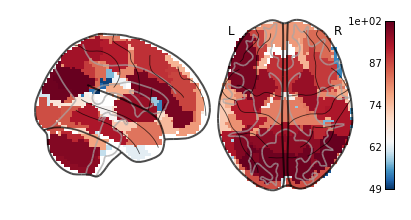

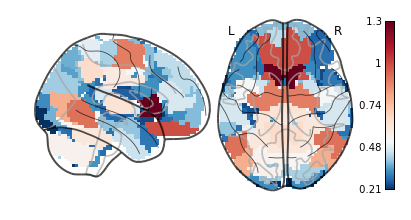

In [202]:

import copy

def mapvec(v,partition):
    new_map = copy.deepcopy(partition)
    im = new_map.get_data()
    
    part = partition.get_data()  
    for i in range(len(v)):
        idxs = np.where(part==(i+1))
        im[idxs] = v[i]
    return new_map

def mapvec2(v,partition):
    new_map = copy.deepcopy(partition)
    im = new_map.get_data()
    
    part = partition.get_data()  
    for i in range(len(v)):
        idxs = np.where(part==(i+1))
        if (i+1) == 1:
            im[idxs] = 0.5
        else:
            im[idxs] = 0
        
    return new_map


im_ref = nib.load('basc_cambridge_sc100.mnc')
im_ref = nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())

#nn_map = mapvec2(site_mean[1,:],im_ref)
#print im_ref.get_data() == nn_map.get_data()
#print(im_ref)
#print(nib.Minc2Image(im_ref.get_data(), im_ref.get_affine()))
#print(copy.deepcopy(nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())))

nn_map = mapvec(site_mean[1,:],im_ref)
cmap_ = vis.get_cmap(nn_map.get_data(),[-0.2,0.5])
plotting.plot_glass_brain(im_ref,
                          cmap=cmap_,
                          colorbar=True ,
                          display_mode='xz'
                         )
nn_map = mapvec(site_mean[10,:],im_ref)
cmap_ = vis.get_cmap(nn_map.get_data(),[-0.2,0.5])
plotting.plot_glass_brain(nn_map,
                          cmap=cmap_,
                          colorbar=True ,
                          display_mode='xz'
                         )



#vis.mat(img[28,:,:])

In [122]:
print im_ref
new_map = copy.deepcopy(im_ref)
print new_map.get_data()

<class 'nibabel.minc1.Minc1Image'>
data shape (46, 64, 53)
affine: 
[[   0.    0.    3.  -78.]
 [   0.    3.    0. -112.]
 [   3.    0.    0.  -50.]
 [   0.    0.    0.    1.]]
metadata:
[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 ..., 
 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0

Exception AttributeError: "'GzipFile' object has no attribute 'fileobj'" in <bound method netcdf_file.close of <nibabel.externals.netcdf.netcdf_file object at 0x10bdab950>> ignored


In [15]:
localizer_tmap_filename

'/Users/christian/nilearn_data/brainomics_localizer/brainomics_data/S02/t_map_left_auditory_&_visual_click_vs_right_auditory&visual_click.nii.gz'

In [ ]:
0.2/(0.2+1.2)

a=np.array([1,2,3])
n=3
(2**(n+4))+n

(16*n)+2*n+1

frame1 = plt.gca()
frame1.axes.get_yaxis().set_visible(True)
frame1.axes.get_yaxis()
        


In [ ]:
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[0, 1:1+2])
ax2 = plt.subplot(gs[1,:-1])
ax3 = plt.subplot(gs[1:, -1])
ax4 = plt.subplot(gs[-1,0])
ax5 = plt.subplot(gs[-1,-2])

In [536]:

reload(vis.matrix)
t, prob = stats.ttest_ind(list_conn_sites[1],list_conn_sites[5],1,equal_var=False)
t, prob

vis.matrix.mat(ts.vec2mat(prob)*(ts.vec2mat(prob)<0.001))

cmap = vis.matrix.get_cmap(prob,[0,1])

import matplotlib as mpl
fig = plt.figure(figsize=(3,3))
ax1 = fig.add_axes([0.8, 0.05, 0.1, 0.9])
vis.matrix.color_bar_vertical(ax1, cmap, [0,1])
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.1])
vis.matrix.color_bar_horizontal(ax1, cmap, [0,1])

plt.subplot(grid2[0, :])

2+2

TypeError: reload() argument must be module